In [33]:
!python -m spacy download ru_core_news_md

DEPRECATION: Loading egg at /home/evgeniy/.local/bin/miniconda3/envs/nlp-env/lib/python3.11/site-packages/huggingface_hub-0.18.0-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 MB 9.9 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')


In [34]:
!python -m spacy download uk_core_news_lg

DEPRECATION: Loading egg at /home/evgeniy/.local/bin/miniconda3/envs/nlp-env/lib/python3.11/site-packages/huggingface_hub-0.18.0-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
     ━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/231.2 MB 104.8 kB/s eta 0:34:32^C
     ━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/231.2 MB 104.8 kB/s eta 0:34:32
ERROR: Operation cancelled by user


In [1]:
import pandas as pd
import spacy

In [2]:
import re
from typing import List

In [4]:
nlp_uk = spacy.load("uk_core_news_md")
nlp_ru = spacy.load("ru_core_news_md")

df_test = pd.read_csv('../data/nlp-ua-locations-extractions/test.csv')
df_test.sample(5)

,text_id,text,locations
37,37,☀️Цього тижня на киян чекає спекотна та сонячн...,[]
312,312,Ще ракета на Київ.,[]
242,242,У парку «Центральний» з’явилося в’язане «Волон...,[]
110,110,Ми продовжуємо знайомити вас із цікавими гастр...,[]
256,256,⚡️Суд избрал меру пресечения Игорю Коломойском...,[]


In [7]:
doc = nlp_uk(df_test.loc[129, "text"])

In [4]:
df_val = pd.read_csv('data/mantis_analytics_location_detection/labeling_sample.csv', converters={"locations": eval})

In [5]:
def predict(x):
    return [str(e) for e in nlp_uk(x).ents if e.label_ == "LOC"] + [str(e) for e in nlp_ru(x).ents if e.label_ == "LOC"]

In [6]:
df_val['locations_pred'] = df_val['text'].apply(predict)

In [23]:
def hard_processing(text):
    text = re.sub(r"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'\b\w\b\s?', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

def comp_metric(y_true: List[List[str]], y_pred: List[List[str]]):
    assert len(y_true) == len(y_pred)
    tp, fp, fn, p,  = 0.0, 0.0, 0.0, 0.0

    for y_true_sample, y_pred_sample in zip(y_true, y_pred):
        y_true_sample = set([hard_processing(s) for s in y_true_sample])
        y_pred_sample = set([hard_processing(s) for s in y_pred_sample])

        tp += len(y_true_sample & y_pred_sample)
        fp += len(y_pred_sample - y_true_sample)
        fn += len(y_true_sample - y_pred_sample)
        p += len(y_true_sample)

        assert p == tp + fn

    if tp + fp == 0:
        if p == 0:
            precision = 1.0
        else:
            precision = 0.0
    else:
        precision = tp/(tp + fp)

    if tp + fn == 0:
        if p == 0:
            recall = 1.0
        else:
            recall = 0.0
    else:
        recall = tp/(tp + fn)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    
    # print(precision, recall)
    return round(f1, 8)


In [15]:
def local_f1(y_true, y_pred):
    y_true_sample = set([hard_processing(s) for s in y_true])
    y_pred_sample = set([hard_processing(s) for s in y_pred])

    tp = len(y_true_sample & y_pred_sample)
    fp = len(y_pred_sample - y_true_sample)
    fn = len(y_true_sample - y_pred_sample)
    p = len(y_true_sample)
    assert p == tp + fn

    if tp + fp == 0:
        if p == 0:
            precision = 1.0
        else:
            precision = 0.0
    else:
        precision = tp/(tp + fp)

    if tp + fn == 0:
        if p == 0:
            recall = 1.0
        else:
            recall = 0.0
    else:
        recall = tp/(tp + fn)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    
    # print(precision, recall)
    return round(f1, 8)


In [24]:
df_val['local_f1'] = df_val[['locations', 'locations_pred']].apply(lambda x: local_f1(x['locations'], x['locations_pred']), axis=1)

In [25]:
comp_metric(df_val['locations'], df_val['locations_pred'])

0.64367816

In [28]:
def comp_metric(y_true: List[List[str]], y_pred: List[List[str]]):
    assert len(y_true) == len(y_pred)
    tp, fp, fn = 0.0, 0.0, 0.0

    for y_true_sample, y_pred_sample in zip(y_true, y_pred):
        y_true_sample = set([hard_processing(s) for s in y_true_sample])
        y_pred_sample = set([hard_processing(s) for s in y_pred_sample])
        tp += len(set(y_true_sample) & set(y_pred_sample))
        fp += len(set(y_pred_sample) - set(y_true_sample))
        fn += len(set(y_true_sample) - set(y_pred_sample))
    
    precision = tp / (tp + fp) if tp + fp != 0 else 0.0 if tp + fn != 0.0 else 1.0
    recall = tp / (tp + fn) if tp + fn != 0 else 1.0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0.0

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [29]:
comp_metric(df_val['locations'], df_val['locations_pred'])

{'precision': 0.509090909090909, 'recall': 0.875, 'f1': 0.6436781609195402}

In [43]:
df_test['locations'] = df_test['text'].apply(predict)

In [44]:
df_test[['text_id', 'locations']].to_csv('spacy_ukru_baseline.csv', index=False)

## With langdetect

In [60]:
import langid

In [61]:
langid.set_languages(['ru', 'uk'])

In [62]:
df_test['lang'] = df_test['text'].apply(lambda x: langid.classify(x)[0])

In [78]:
import emoji

In [82]:
def contains_emoji(text):
    for char in text:
        if emoji.is_emoji(char):
            return True
    else:
        return False

In [95]:
def predict(x):
    lang = None
    try:
        lang = langid.classify(x)[0]
    except:
        pass

    if lang == 'ru':
        res = [str(e) for e in nlp_ru(x).ents if e.label_ == "LOC" and not contains_emoji(str(e))]
    else:
        res = [str(e) for e in nlp_uk(x).ents if e.label_ == "LOC" and not contains_emoji(str(e))]
    
    return res


In [96]:
df_test['locations'] = df_test['text'].apply(predict)

In [97]:
df_test[['text_id', 'locations']].to_csv('spacy_ukru.csv', index=False)

In [98]:
df_test

,text_id,text,locations,lang
0,0,"❗️Кількість поранених зросла до трьох, – Кличк...",[Київ],uk
1,1,"🥤В Києві за 91,13 млн гривень починаються робо...","[Києві, Шулявського шляхопроводу, Шулявського ...",uk
2,2,▪️Сьогодні вночі росіяни завдали ракетного уда...,"[Гоголеве, Миргородського району, Полтавської ...",uk
3,3,Наразі у запасах росіян найбільше балістичних ...,[],uk
4,4,"⛸В один день, 29 серпня, ДП ""Центральна учбово...","[проспекті Академіка Глушкова, 9]",uk
...,...,...,...,...
472,472,Допомога на відновлення: п’ять громад Київщини...,"[Київщини, Україні, Київської області, Бучансь...",uk
473,473,Пророцтво Стругацьких: незвичайна бактерія Бра...,"[Землі, Червоне кільце]",uk
474,474,Із 1 вересня УГКЦ і ПЦУ перейшли на новий церк...,[],uk
475,475,🦇 У Києві з Дніпра виловили іноземця в масці Б...,"[Києві, Дніпра, Дніпро]",uk


In [99]:
df_test.values

array([[0,
        '❗️Кількість поранених зросла до трьох, – Кличко\n\nКиїв — пряма трансляція 👈',
        list(['Київ']), 'uk'],
       [1,
        '🥤В Києві за 91,13 млн гривень починаються роботи зі знесення будівлі цеху №5 заводу “Більшовик”, які необхідні для продовження реконструкції “Шулявського шляхопроводу”.\n\n🤝Договір на проведення цих робіт КП "Дирекція будівництва шляхово-транспортних споруд Києва" уклало з ТОВ “Мостицький-2”, відхиливши вигіднішу пропозицію в тендері.\n\n🧐“Мостицький-2” відоме як постійний генпідрядник будівництва скандальних житлових комплексів Edelburg Development, яке пов\'язують з сином екс-мера столиці Леоніда Черновецького Степаном👤. \n\nЦі компанії тісно сплетені бізнесовими та навіть родинними нитями👨\u200d👩\u200d👧\u200d👦.\n🧶Водночас зв\'язки обраного для знесення цеху підрядника ведуть до ще однієї одіозної фігури - сумнозвісного столичного забудовника Максима Микитася, компанія з орбіти якого майже за 1,5 млрд гривень власне займається всією рек

<Axes: xlabel='lang'>

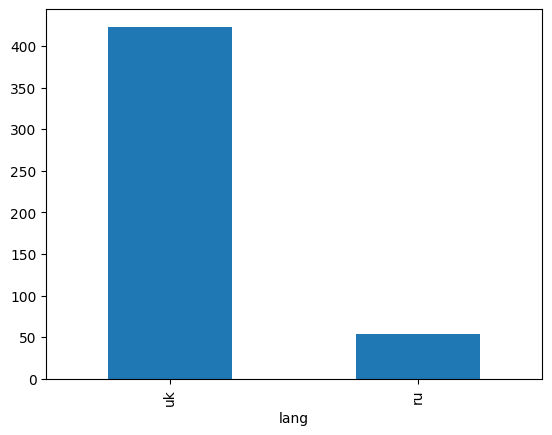

In [53]:
df_test['lang'].value_counts().plot.bar()

In [54]:
df_test[['text_id', 'text', 'lang', 'locations']].to_csv('for_inspection.csv', index=False)